In [5]:
from Data_Enrichment import get_features

RAW_DIR = "data/raw"
df_feats, feature_cols = get_features(RAW_DIR)
df_feats = df_feats[ (df_feats['season_end_year'] != 2026)]



/workspaces/Machine-learning/Data_Enrichment.py:300: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ballon_dor_winner"] = df["ballon_dor_winner"].fillna(False).astype(bool)


In [6]:
def corr_var(df_feats):
    df_feats.drop(columns=['clean_sheets', 'nb_in_group', 'matches_played', 'g_per90', 'ga_per90'], inplace=True)
    return df_feats
df = corr_var(df_feats)

In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
X_numeric = df.select_dtypes(include=['int64', 'float64'])


In [ ]:
from sklearn.ensemble import RandomForestRegressor
np.random.seed(30) #we fix the seed so we can reproduce the data any time

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_numeric, df["ballon_dor_winner"])

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
ncol=X_numeric.shape[1]-1
data_df=X_numeric.iloc[:,0:ncol]

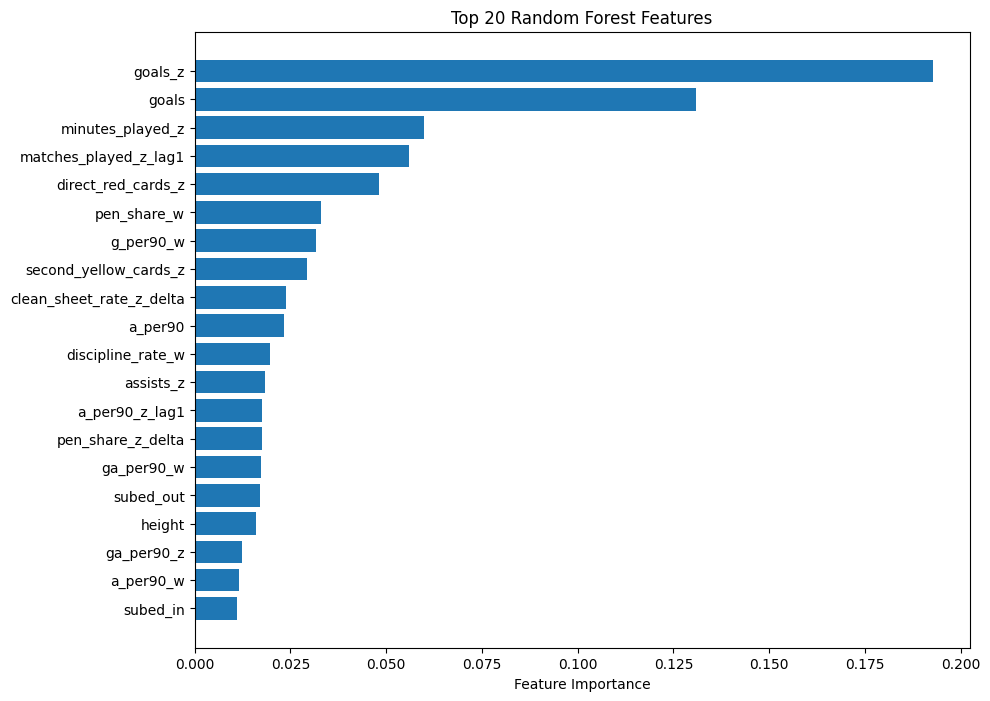

In [15]:
import matplotlib.pyplot as plt

feature_names = X_numeric.columns  # columnas usadas en entrenamiento
importances = rf.feature_importances_

# Top 20 features más importantes
top_idx = importances.argsort()[::-1][:20]

plt.figure(figsize=(10, 8))
plt.barh(feature_names[top_idx], importances[top_idx])
plt.xlabel("Feature Importance")
plt.title("Top 20 Random Forest Features")
plt.gca().invert_yaxis()  # más importante arriba
plt.show()


In [ ]:
# Filtro limpio: deja las variables temporales relevantes + identificación + target
df_model = df.filter(
    regex=r'(player_id|player_name|lag1|delta|_w$|height|main_position|position|season_end_year|ballon_dor_winner)'
).copy()


In [5]:
# Entrenamiento: todas las temporadas hasta 2024
train = df_model[df_model['season_end_year'] < 2025]

# Predicción: temporada 2025
test = df_model[df_model['season_end_year'] == 2025]


In [6]:
# Features y target
X_train = train.drop(columns=['ballon_dor_winner'])
y_train = train['ballon_dor_winner']

X_test = test.drop(columns=['ballon_dor_winner'])
y_test = test['ballon_dor_winner']


In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identificar tipos
num_cols = X_train.select_dtypes(include='number').columns.drop(['season_end_year'], errors='ignore')
cat_cols = ['position', 'main_position']

# Preprocesador
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='drop')


In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight='balanced_subsample'
    ))
])

rf.fit(X_train, y_train)


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
from sklearn.metrics import classification_report

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3503

    accuracy                           1.00      3503
   macro avg       1.00      1.00      1.00      3503
weighted avg       1.00      1.00      1.00      3503



In [10]:
test = test.copy()
test['pred_proba'] = y_proba

top_candidates = (
    test[['player_name', 'season_end_year', 'pred_proba']]
    .sort_values('pred_proba', ascending=False)
)

top_candidates.head(10)


,player_name,season_end_year,pred_proba
40075,Robert Lewandowski (38253),2025,0.036667
43756,Bryan Mbeumo (413039),2025,0.033333
56680,Julián Alvarez (576024),2025,0.033333
43160,Lautaro Martínez (406625),2025,0.030000
34628,Kylian Mbappé (342229),2025,0.020000
38500,Federico Valverde (369081),2025,0.020000
43576,Raphinha (411295),2025,0.016667
65866,Iago Aspas (72047),2025,0.016667
6136,Harry Kane (132098),2025,0.016667
44223,Erling Haaland (418560),2025,0.016667


In [11]:
# Extraer el modelo RandomForest ya entrenado
model = rf.named_steps['model']

# Obtener las columnas transformadas del preprocesador
# (OneHotEncoder genera columnas nuevas, así que hay que recuperarlas)
encoder = rf.named_steps['prep'].named_transformers_['cat']
encoded_cols = encoder.get_feature_names_out(['position', 'main_position'])

num_cols_scaled = rf.named_steps['prep'].named_transformers_['num'].feature_names_in_

# Combinar nombres de todas las features finales del pipeline
all_features = np.concatenate([num_cols_scaled, encoded_cols])

# Importancias del modelo
importances = model.feature_importances_

# Crear DataFrame ordenado
feat_imp = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values('importance', ascending=False)

feat_imp.head(20)


,feature,importance
17,matches_played_z_lag1,0.144274
5,a_per90_z_lag1,0.121486
3,g_per90_z_lag1,0.099683
1,ga_per90_z_lag1,0.091303
13,pen_share_z_lag1,0.077015
4,g_per90_z_delta,0.057082
21,a_per90_w,0.052571
2,ga_per90_z_delta,0.047925
20,g_per90_w,0.040171
6,a_per90_z_delta,0.037411
